In [1]:
import sys
import os
from datetime import datetime
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
sys.path.append(os.path.abspath('../src'))
from lib import (
    train_and_evaluate_models,
    create_eui_comparison_plots,
    evaluate_model_strategies,
    calculate_average_metrics,
    create_error_distribution_plots
)

In [3]:
output_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(output_path)
merged_df = merged_df.rename(columns={'total_year': 'hdd_total_year'})

# GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporal)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

np.random.seed(123)
merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

In [4]:
features = [
    "hdd_total_year", 
    "cdd_total_year", 
    "GDP_per_capita", 
    "Urbanization_Rate_2022",
    "latitude",
    "longitude",  
    "Paris_Agreement",
    "Subnational HDI", 
    "Educational index", 
    "Income index",
    "2m_temperature_2023_avg",
    "2m_dewpoint_temperature_2023_avg",
    "total_precipitation_2023"
]

feature_abbreviations = {
    "hdd_total_year": "HDD",
    "cdd_total_year": "CDD", 
    "GDP_per_capita": "GDP",
    "Urbanization_Rate_2022": "URB",
    "latitude": "Lat",
    "longitude": "Long",
    "Paris_Agreement": "Paris",
    "Subnational HDI": "HDI", 
    "Educational index": "EDU" , 
    "Income index": "Income",
    "2m_temperature_2023_avg": "Temp",
    "2m_dewpoint_temperature_2023_avg": "Dew",
    "total_precipitation_2023": "Precip"
}

target_columns = [
    "Residential EUI (kWh/m2/year)",
    "Non-residential EUI (kWh/m2/year)"
]

regions = ['Asia & Oceania', 'Europe', 'Africa', 'Central and South America', 'Northern America']


# KNN

In [5]:
knn_params = {
    'n_neighbors': 5,          # number of neighbors
    'weights': 'distance',     # weight points by inverse of their distance
    'algorithm': 'auto',       # automatically choose the best algorithm
    'leaf_size': 30,          # leaf size for tree algorithms
    'p': 2,                   # power parameter for Minkowski metric (2 = Euclidean distance)
    'metric': 'minkowski',     # distance metric to use
    'n_jobs': -1              # use all available cores
}

### KNN - Within Domain

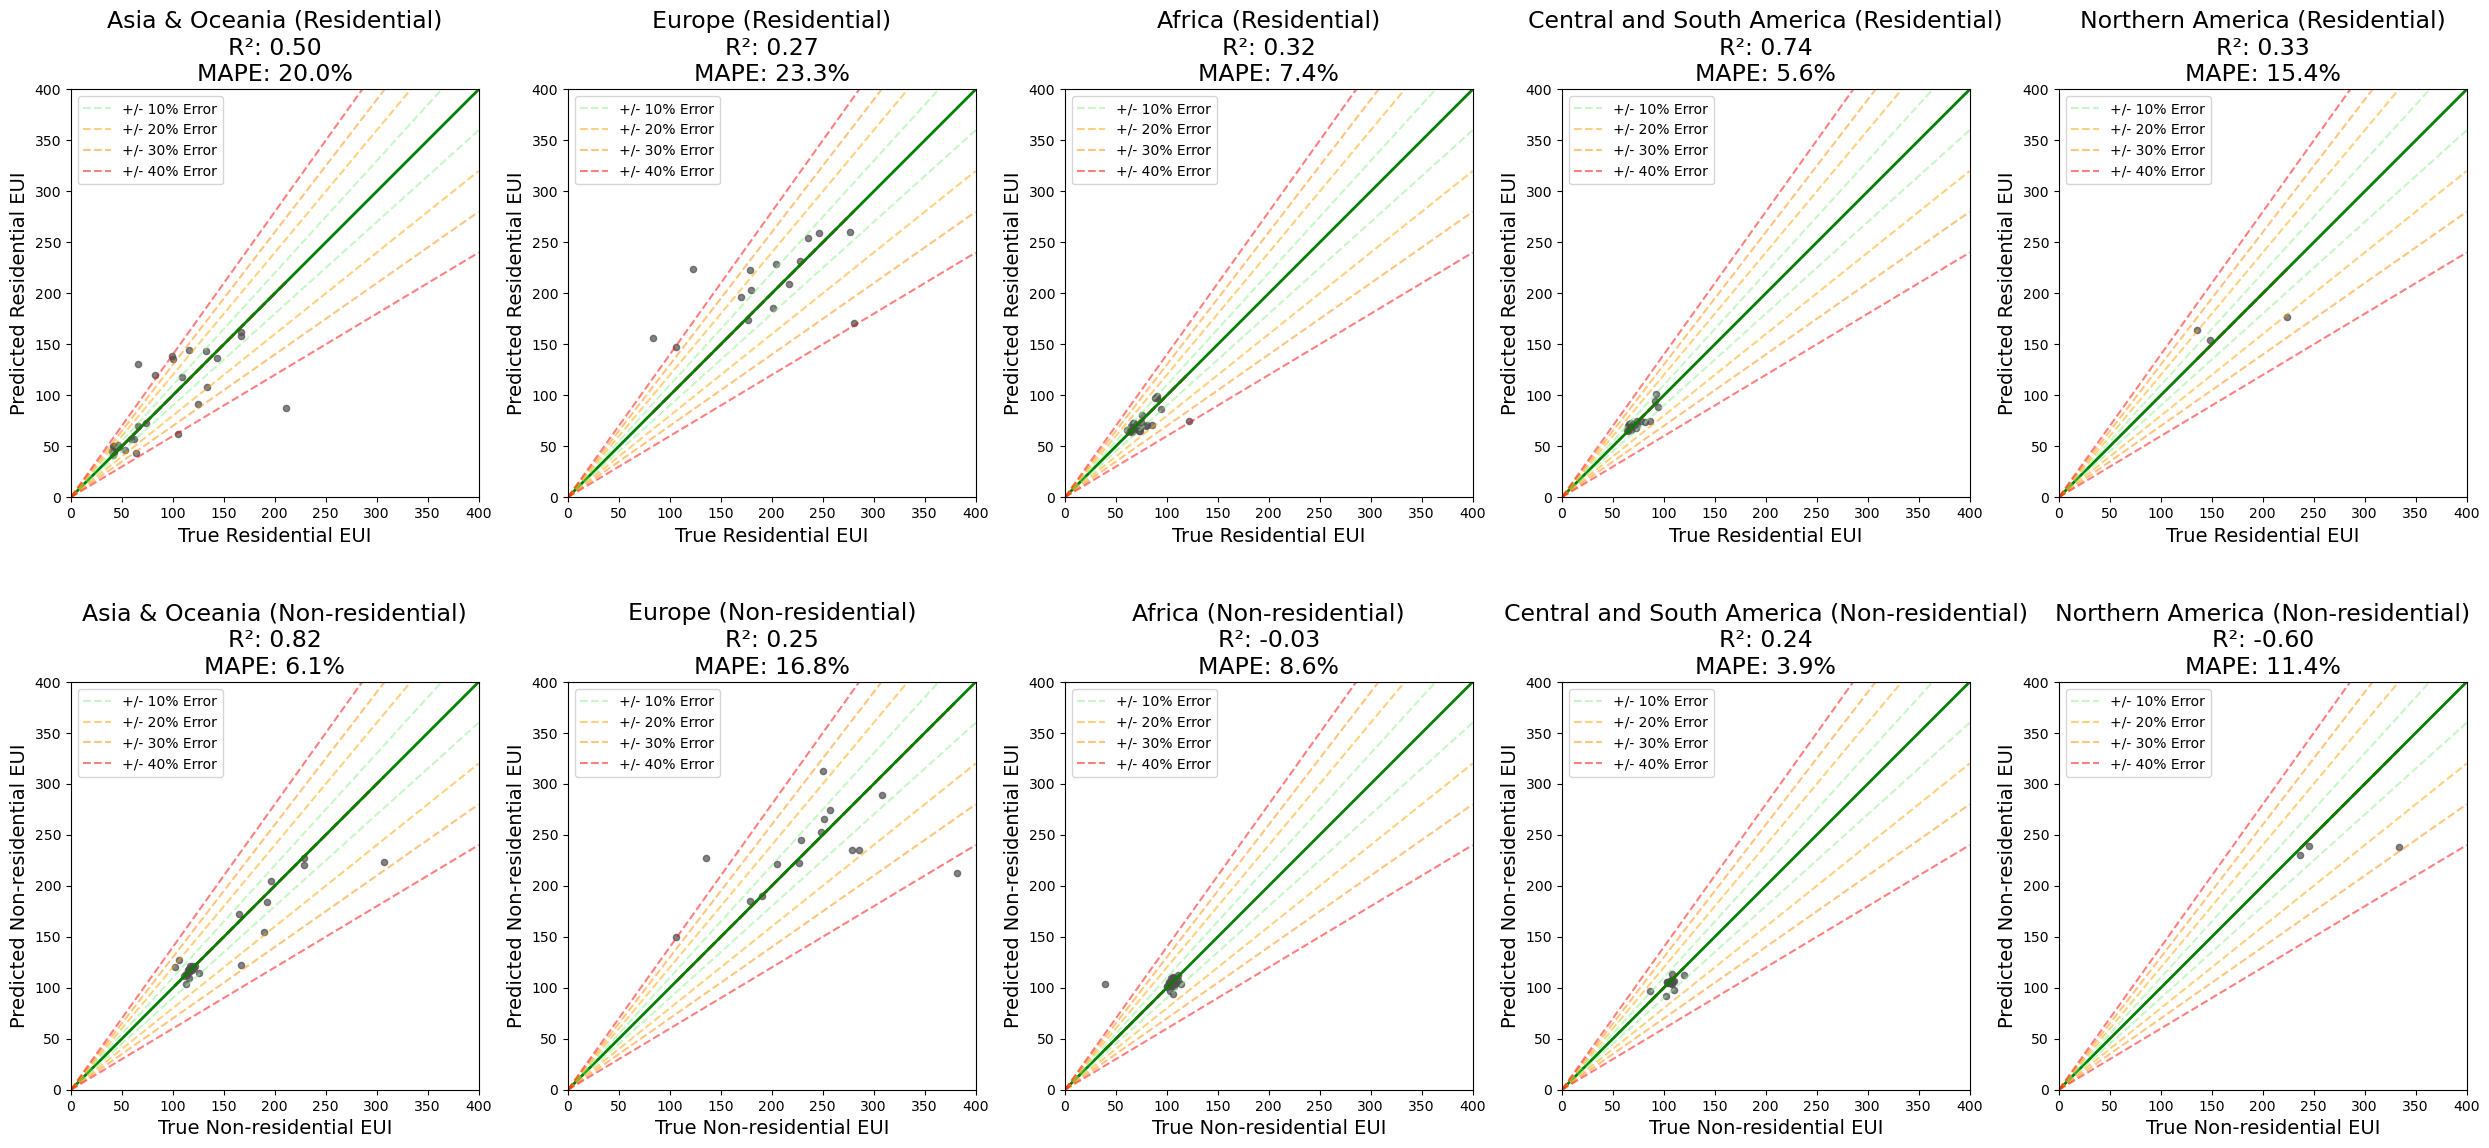

In [6]:
# Within-domain
model_knn_within = KNeighborsRegressor(**knn_params)
results_knn_within = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_knn_within,
    strategy='within_domain'
)

create_eui_comparison_plots(results_knn_within, 
    save_path='../figures/model_plots/knn_within_domain_eui_predictions.png')

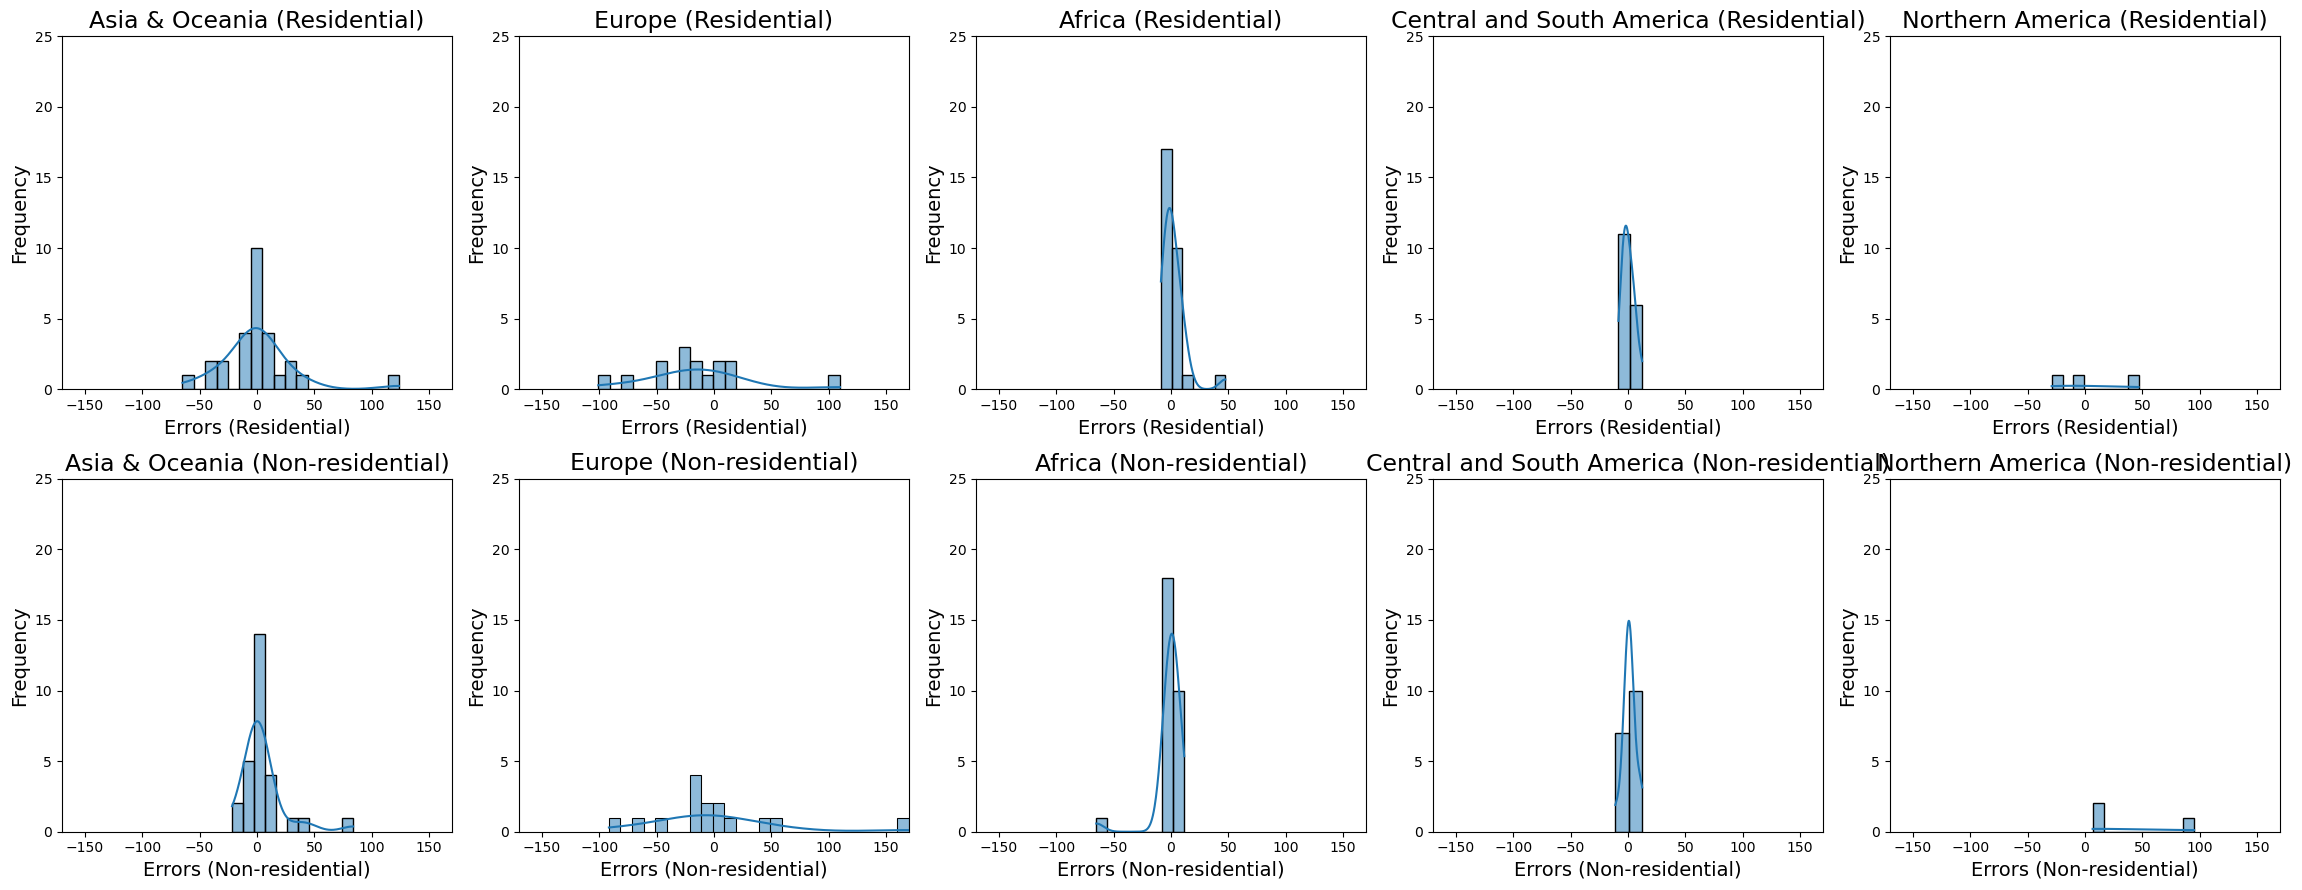

In [7]:
create_error_distribution_plots(results_knn_within,
    save_path='../figures/model_plots/knn_within_domain_error_distribution.png')

KNN - Cross Domain

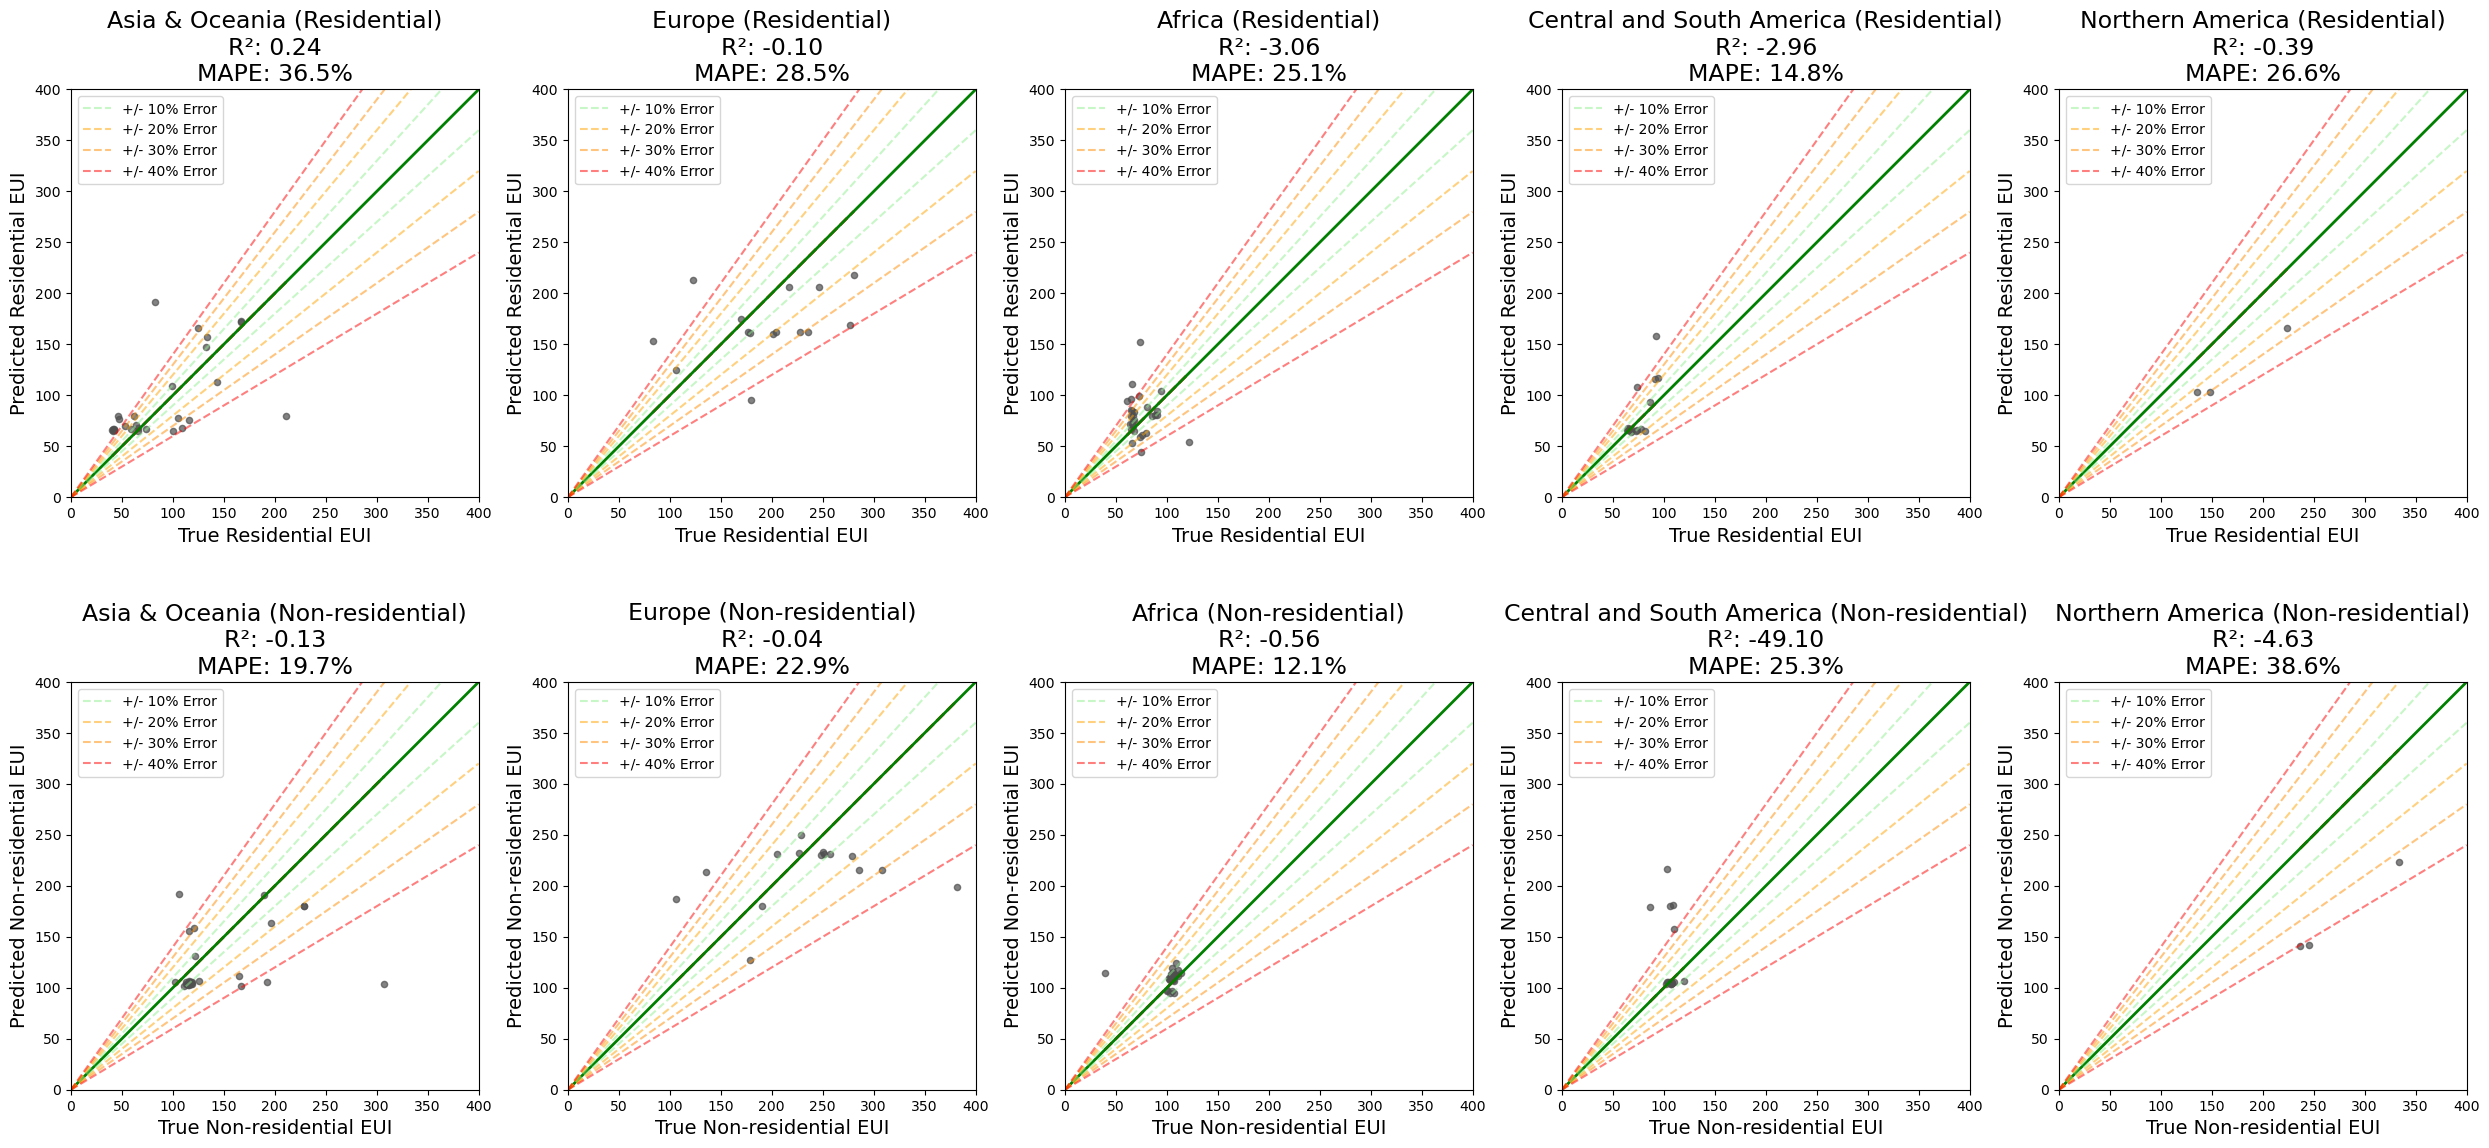

In [8]:
# Cross-domain
model_knn_cross = KNeighborsRegressor(**knn_params)
results_knn_cross = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_knn_cross,
    strategy='cross_domain'
)

create_eui_comparison_plots(results_knn_cross,
    save_path='../figures/model_plots/knn_cross_domain_eui_predictions.png')

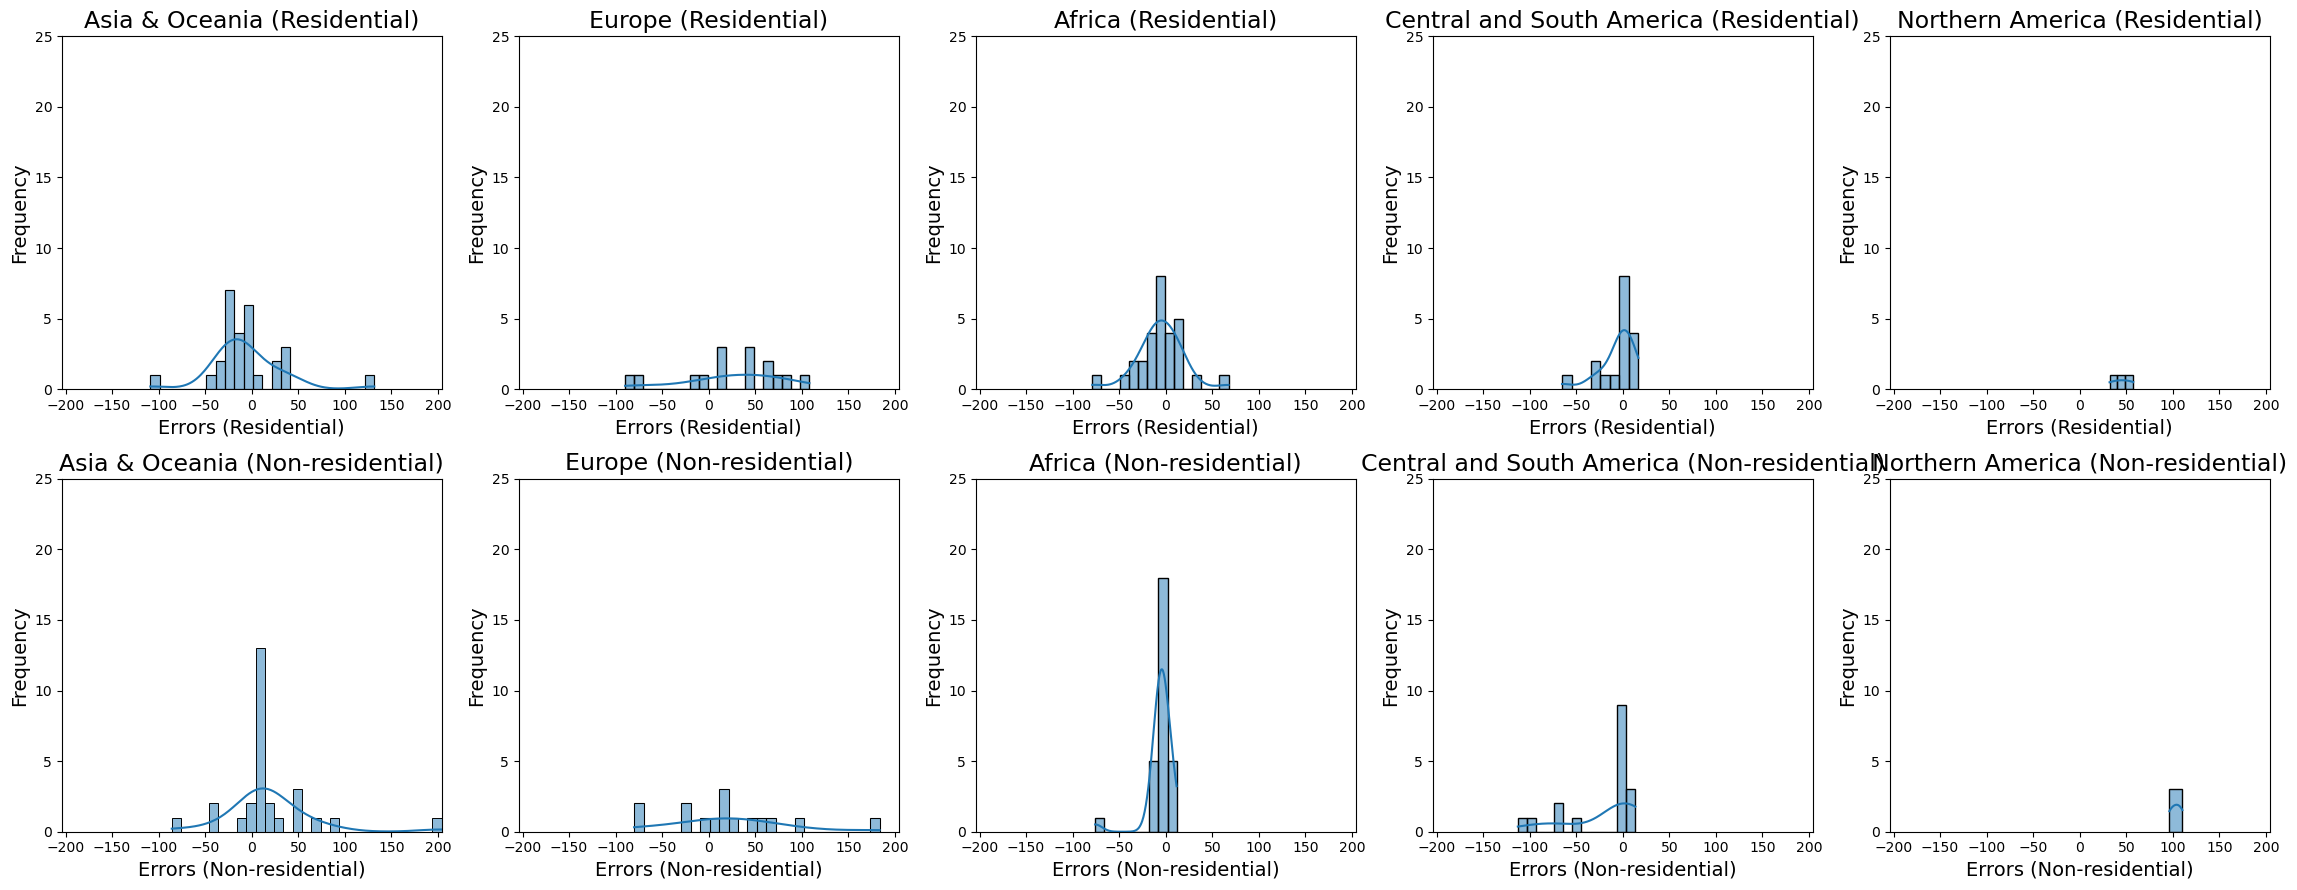

In [9]:
create_error_distribution_plots(results_knn_cross,
    save_path='../figures/model_plots/knn_cross_domain_error_distribution.png')

### KNN - All Domain

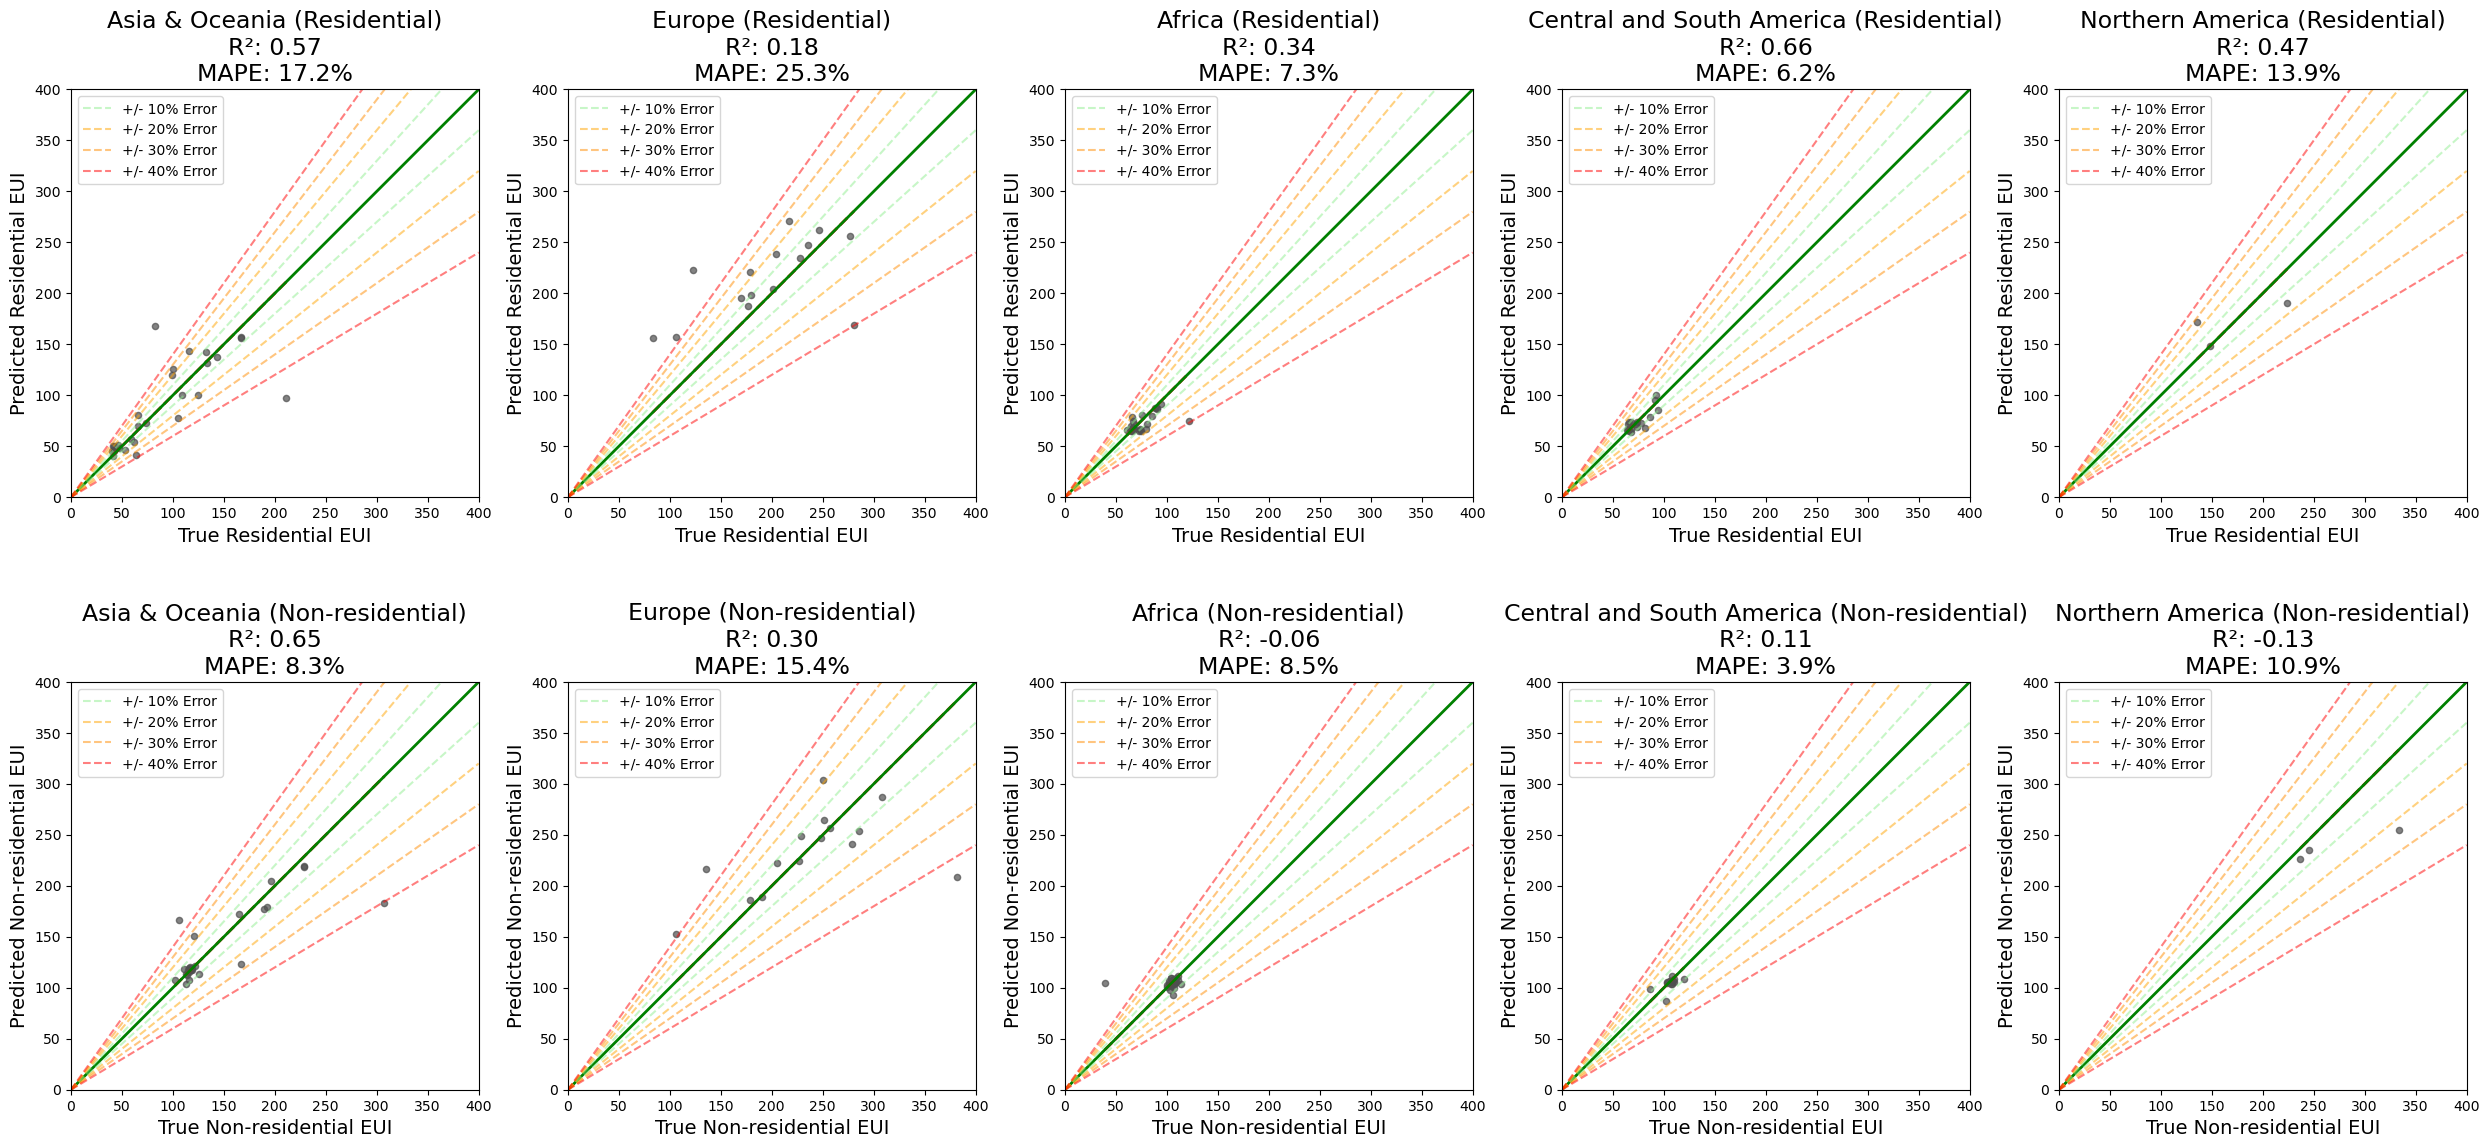

In [10]:
# All-domain
model_knn_all = KNeighborsRegressor(**knn_params)
results_knn_all = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_knn_all,
    strategy='all_domain'
)

create_eui_comparison_plots(results_knn_all,
    save_path='../figures/model_plots/knn_all_domain_eui_predictions.png')

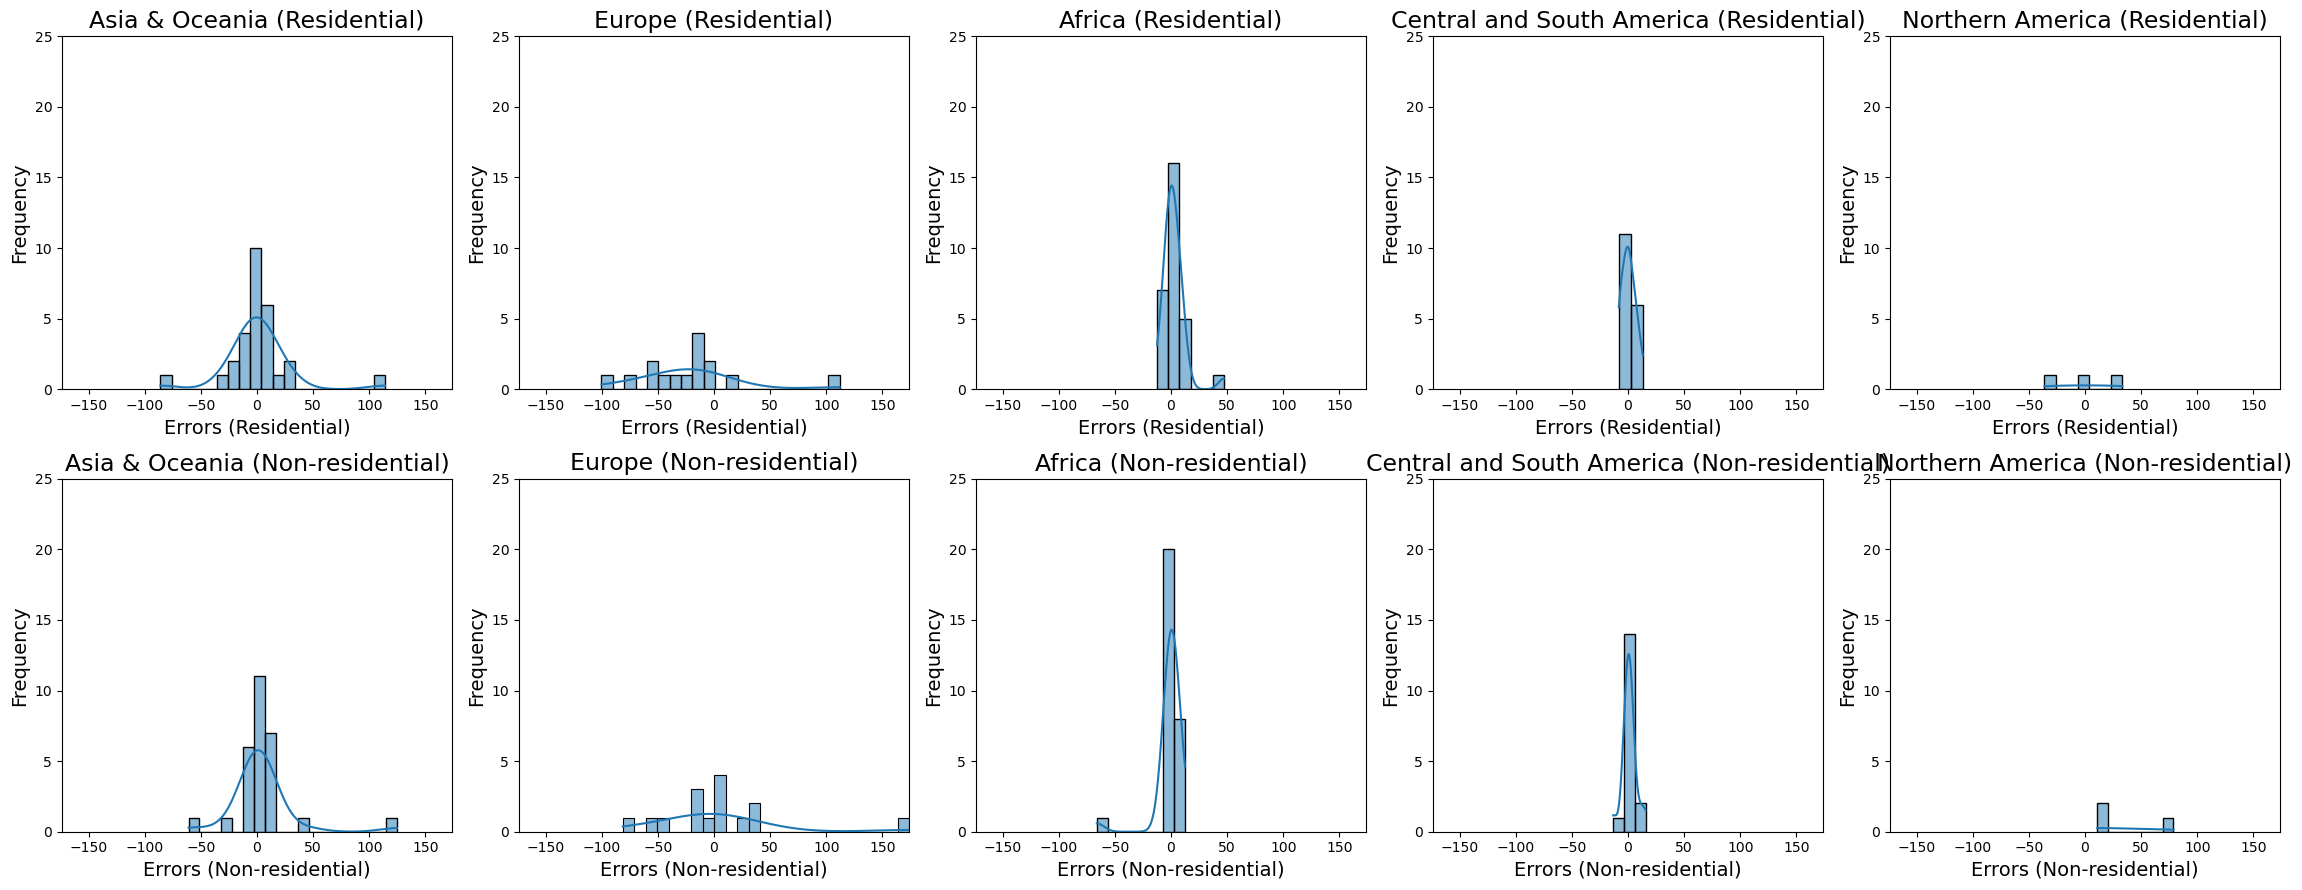

In [11]:
create_error_distribution_plots(results_knn_all,
    save_path='../figures/model_plots/knn_all_domain_error_distribution.png'
    )

In [12]:
knn_detailed_results = evaluate_model_strategies(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model_type=KNeighborsRegressor,
    feature_abbreviations=feature_abbreviations,
    model_details=  ", ".join(f"{k} = {v}" for k, v in knn_params.items())
)

knn_average_results = calculate_average_metrics(knn_detailed_results).reset_index()
knn_average_results

,Target,Strategy,Model,Model Details,Features Used,Features Abbreviated,MAPE,R²,MSE,RMSE,MAE,WAPE
0,Non-residential EUI (kWh/m2/year),within_domain,KNeighborsRegressor,"n_neighbors = 5, weights = distance, algorithm...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,9.72,0.101,1387.546,30.641,19.152,9.38
1,Non-residential EUI (kWh/m2/year),cross_domain,KNeighborsRegressor,"n_neighbors = 5, weights = distance, algorithm...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,23.72,-10.304,4053.580,56.702,44.015,22.80
2,Non-residential EUI (kWh/m2/year),all_domain,KNeighborsRegressor,"n_neighbors = 5, weights = distance, algorithm...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,9.82,0.142,1271.061,30.492,18.557,9.30
3,Residential EUI (kWh/m2/year),within_domain,KNeighborsRegressor,"n_neighbors = 5, weights = distance, algorithm...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,15.46,0.350,1022.801,27.279,19.665,15.08
4,Residential EUI (kWh/m2/year),cross_domain,KNeighborsRegressor,"n_neighbors = 5, weights = distance, algorithm...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,26.36,-1.350,1652.408,38.398,30.626,25.20
5,Residential EUI (kWh/m2/year),all_domain,KNeighborsRegressor,"n_neighbors = 5, weights = distance, algorithm...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,15.06,0.377,1015.063,26.659,19.228,14.38


In [13]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
knn_detailed_results.to_csv(f'../results/{timestamp}_knn_detailed_results.csv')
knn_average_results.to_csv(f'../results/{timestamp}_knn_average_results.csv')

# 